In [1]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random

In [2]:
# from tensorboard import notebook

# # 初始化 SummaryWriter，日志将保存在'runs'目录下
# writer = SummaryWriter(f"./logs/{datetime.datetime.now()}")

# # 启动 TensorBoard 并指定日志目录
# notebook.start("--logdir runs")

# # 可选：创建一个链接直接跳转到 TensorBoard 界面
# # notebook.display(height=400)

In [3]:
# %matplotlib qt5

In [4]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, hidden_size = 64):
        super(Actor, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_mean = torch.nn.Linear(hidden_size, n_action)
        self.fc_std = torch.nn.Linear(hidden_size, n_action)

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        mu = torch.tanh(self.fc_mean(F.relu(x))) * 1.0
        # std = F.softplus(self.fc_std(F.relu(x))) + 0e-3
        std = torch.ones_like(mu) * 1.0  # 固定标准差，增强探索

        return mu, std

        
class Critic(nn.Module):
    def __init__(self, n_state, hidden_size=64):
        super(Critic, self).__init__()

        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        return x


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

def shaped_reward(state, original_reward):
    position, velocity = state
    # 增加与位置相关的奖励（鼓励向右侧山顶移动）
    position_reward = 10 * (position + 0.5)  # 谷底位置约为 -0.5，向右侧移动时奖励增加
    # 增加与速度方向相关的奖励（鼓励沿目标方向加速）
    velocity_reward = 5 * velocity if position > -0.5 else 0  # 右侧加速时奖励更高
    return original_reward + position_reward + velocity_reward

class PPOContinuous(nn.Module):

    def __init__(self, n_state, n_action, n_hidden = 64, actor_lr=1e-4, critic_lr=1e-4, lmbda=0.1, epochs=10, eps=0.01, gamma=0.99, device="cpu"):
        super(PPOContinuous, self).__init__()
        print(f"{n_state=}, {n_action=}, {n_hidden=}")

        self.actor = Actor(n_state, n_action, hidden_size=n_hidden)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)

        self.critic = Critic(n_state, hidden_size=n_hidden)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)

        self.lmbda = lmbda
        self.gamma = gamma
        self.eps = eps
        self.epochs = epochs
        self.device = device

    def take_action(self, state, eval = False):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)

        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()

        if not eval:
            r = random.uniform(-1, 1) * 0.0
        else:
            r = 0.

        # return [np.clip(action.item() + r, -1, 1)]
        return [action.item()]
        

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device) 

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta)

        mu, std = self.actor(states)
        action_dist = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dist.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            # print(f"====={mu.max()=}, {std.max()=}, {std.min()=}")

            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)

            ratio = torch.exp(log_probs - old_log_probs)
            # ratio = torch.clamp(ratio, min=-1e6, max=1e6)
            l1 = ratio * advantage
            l2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            l3 = - torch.min(l1, l2)

            actor_loss = torch.mean(l3)
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            # print(f"====={actor_loss=}, {critic_loss=}, {l1.min()=}, {ratio.min()=}, {ratio.max()=} \n")
            

            self.actor_opt.zero_grad()
            self.critic_opt.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_opt.step()
            self.critic_opt.step()
        print(f"====actor_loss: {actor_loss.detach().item()}, critic_loss: {critic_loss.detach().item()}")

        

In [5]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 1000
hidden = 128

gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.4

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"


env = gym.make(env_name)
torch.manual_seed(0)
print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPOContinuous(n_state=state_dim, n_action=action_dim, n_hidden=hidden,actor_lr=actor_lr, critic_lr=critic_lr)

state space: [-1.0210897  -0.06613877]
action space: Box(-1.0, 1.0, (1,), float32)
n_state=2, n_action=1, n_hidden=128


In [6]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    episode_return = 0

    for epoch in range(num_episodes//100):
    
        for i in tqdm(range(100), position=0, desc=f"###{epoch} : {episode_return} "):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state, _ = env.reset()
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                # reward = shaped_reward(state, reward)
                
    
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)


    return return_list
        
return_list = train_on_policy_agent(env, agent, num_episodes)

###0 : 0 :   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/qj/rq98z_3924x5tz6c8ln97_mr0000gn/T/ipykernel_8637/2254667449.py:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)


====actor_loss: 0.11371704936027527, critic_loss: 0.022839700803160667
====actor_loss: 0.11151620745658875, critic_loss: 0.024444082751870155
====actor_loss: 0.1052183285355568, critic_loss: 0.02169979363679886
====actor_loss: 0.10397762805223465, critic_loss: 0.024755919352173805
====actor_loss: 0.1172715350985527, critic_loss: 0.026495415717363358
====actor_loss: 0.1023482158780098, critic_loss: 0.023503461852669716
====actor_loss: 0.09975001960992813, critic_loss: 0.023201793432235718
====actor_loss: 0.09782403707504272, critic_loss: 0.022361934185028076
====actor_loss: 0.10194221138954163, critic_loss: 0.02495480515062809
====actor_loss: 0.09899891167879105, critic_loss: 0.02103535085916519
====actor_loss: 0.08472331613302231, critic_loss: 0.016792919486761093
====actor_loss: 0.0946168303489685, critic_loss: 0.021112021058797836
====actor_loss: 0.0877777487039566, critic_loss: 0.020586198195815086
====actor_loss: 0.08615104109048843, critic_loss: 0.019105928018689156
====actor_loss

###1 : -99.66287154005163 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.03490149974822998, critic_loss: 0.018697421997785568
====actor_loss: 0.045810867100954056, critic_loss: 0.022461475804448128
====actor_loss: 0.038663655519485474, critic_loss: 0.02079804241657257
====actor_loss: 0.0329531766474247, critic_loss: 0.018239302560687065
====actor_loss: 0.040044575929641724, critic_loss: 0.02096921019256115
====actor_loss: 0.040500201284885406, critic_loss: 0.02274749055504799
====actor_loss: 0.026307161897420883, critic_loss: 0.018866365775465965
====actor_loss: 0.046747837215662, critic_loss: 0.032142963260412216
====actor_loss: 0.04462771117687225, critic_loss: 0.026877563446760178
====actor_loss: 0.03512342646718025, critic_loss: 0.023827405646443367
====actor_loss: 0.03615109622478485, critic_loss: 0.021877193823456764
====actor_loss: 0.03722740709781647, critic_loss: 0.027619892731308937
====actor_loss: 0.03794194757938385, critic_loss: 0.023060280829668045
====actor_loss: 0.03411804884672165, critic_loss: 0.019960010424256325
====act

###2 : -105.23209086005542 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.0019457896705716848, critic_loss: 0.0377129502594471
====actor_loss: 0.02196708507835865, critic_loss: 0.022346606478095055
====actor_loss: 0.016389820724725723, critic_loss: 0.0420137457549572
====actor_loss: 0.019806308671832085, critic_loss: 0.024101439863443375
====actor_loss: 0.016901561990380287, critic_loss: 0.027864309027791023
====actor_loss: 0.009399529546499252, critic_loss: 0.020314684137701988
====actor_loss: 0.014242973178625107, critic_loss: 0.022136863321065903
====actor_loss: 0.009290979243814945, critic_loss: 0.019429603591561317
====actor_loss: 0.01765693910419941, critic_loss: 0.026472609490156174
====actor_loss: 0.02125030755996704, critic_loss: 0.02339913882315159
====actor_loss: 0.030242012813687325, critic_loss: 0.0691087543964386
====actor_loss: 0.007739890832453966, critic_loss: 0.017860550433397293
====actor_loss: 0.017346877604722977, critic_loss: 0.020892109721899033
====actor_loss: 0.02409786358475685, critic_loss: 0.04224588721990585
===

###3 : -96.79811407935199 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.004360320512205362, critic_loss: 0.02299557626247406
====actor_loss: 0.000153075234265998, critic_loss: 0.02132030762732029
====actor_loss: -0.14419987797737122, critic_loss: 2.839794397354126
====actor_loss: -0.0022411150857806206, critic_loss: 0.031216369941830635
====actor_loss: -0.12845560908317566, critic_loss: 2.957606315612793
====actor_loss: 0.03897203132510185, critic_loss: 0.46730390191078186
====actor_loss: -0.0008267999510280788, critic_loss: 0.08174315840005875
====actor_loss: -0.001952389720827341, critic_loss: 0.021220561116933823
====actor_loss: 0.0025637326762080193, critic_loss: 0.02278519794344902
====actor_loss: 0.007949483580887318, critic_loss: 0.059786293655633926
====actor_loss: 0.021089788526296616, critic_loss: 0.17397020757198334
====actor_loss: 0.008911036886274815, critic_loss: 0.02311355248093605
====actor_loss: 0.0033936481922864914, critic_loss: 0.03148282691836357
====actor_loss: 0.014919192530214787, critic_loss: 0.07207813858985901
=

###4 : -99.04582177471218 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.0018983421614393592, critic_loss: 0.026461264118552208
====actor_loss: -0.0037155705504119396, critic_loss: 0.030247269198298454
====actor_loss: 0.01867138408124447, critic_loss: 0.2317325323820114
====actor_loss: 0.006321528926491737, critic_loss: 0.02440282329916954
====actor_loss: 0.008461317047476768, critic_loss: 0.02475620061159134
====actor_loss: 0.003228070680052042, critic_loss: 0.0211582463234663
====actor_loss: -0.24045740067958832, critic_loss: 0.25829800963401794
====actor_loss: 0.000921307597309351, critic_loss: 0.09050174057483673
====actor_loss: -0.11551548540592194, critic_loss: 0.8268570303916931
====actor_loss: 0.010287920013070107, critic_loss: 0.13527633249759674
====actor_loss: 0.0017755477456375957, critic_loss: 0.028889011591672897
====actor_loss: -0.006384309381246567, critic_loss: 0.01826605573296547
====actor_loss: -0.0016770047368481755, critic_loss: 0.22558672726154327
====actor_loss: 0.007677169516682625, critic_loss: 0.14510512351989746

###5 : 44.944731090798456 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.11469472199678421, critic_loss: 2.227180004119873
====actor_loss: -0.125270277261734, critic_loss: 1.0666553974151611
====actor_loss: -0.024768691509962082, critic_loss: 1.578803300857544
====actor_loss: -0.06496505439281464, critic_loss: 1.8015645742416382
====actor_loss: -0.03854048624634743, critic_loss: 1.1933130025863647
====actor_loss: -0.15002185106277466, critic_loss: 1.3598952293395996
====actor_loss: -0.10744301229715347, critic_loss: 1.1734493970870972
====actor_loss: -0.15468621253967285, critic_loss: 4.09396505355835
====actor_loss: -0.24911050498485565, critic_loss: 1.3734173774719238
====actor_loss: -0.13304226100444794, critic_loss: 1.0216773748397827
====actor_loss: -0.07774270325899124, critic_loss: 0.8219748139381409
====actor_loss: -0.0018345859134569764, critic_loss: 1.8050167560577393
====actor_loss: -0.06326040625572205, critic_loss: 0.7434665560722351
====actor_loss: -0.05084806680679321, critic_loss: 1.3805739879608154
====actor_loss: -0.1119

###6 : 67.39337734381168 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.30340126156806946, critic_loss: 2.6564781665802
====actor_loss: -0.4048140347003937, critic_loss: 4.047082901000977
====actor_loss: -0.2717205584049225, critic_loss: 2.9683139324188232
====actor_loss: -0.22997307777404785, critic_loss: 2.4090921878814697
====actor_loss: -0.5306445956230164, critic_loss: 3.747992992401123
====actor_loss: -0.3236810266971588, critic_loss: 3.6218953132629395
====actor_loss: -0.22420376539230347, critic_loss: 2.05232572555542
====actor_loss: -0.17265814542770386, critic_loss: 2.8136415481567383
====actor_loss: -0.15724153816699982, critic_loss: 2.2256274223327637
====actor_loss: -0.19871406257152557, critic_loss: 2.461296796798706
====actor_loss: -0.29239797592163086, critic_loss: 3.1814663410186768
====actor_loss: 0.012799208052456379, critic_loss: 2.770867109298706
====actor_loss: -0.28441670536994934, critic_loss: 2.4860241413116455
====actor_loss: -0.31903553009033203, critic_loss: 2.5995938777923584
====actor_loss: -0.14061862230300

###7 : 75.39637651823574 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.13841760158538818, critic_loss: 0.5818734765052795
====actor_loss: -0.5067238211631775, critic_loss: 2.230919122695923
====actor_loss: 0.10027718544006348, critic_loss: 1.2931214570999146
====actor_loss: -0.04598141461610794, critic_loss: 0.9132129549980164
====actor_loss: -0.46363821625709534, critic_loss: 2.1748123168945312
====actor_loss: -0.07384184002876282, critic_loss: 0.8848877549171448
====actor_loss: 0.10705910623073578, critic_loss: 1.1733345985412598
====actor_loss: -0.20408883690834045, critic_loss: 0.9295344948768616
====actor_loss: -0.059736043214797974, critic_loss: 0.681810200214386
====actor_loss: 0.06346540153026581, critic_loss: 0.9094195365905762
====actor_loss: -0.19583392143249512, critic_loss: 0.9955309629440308
====actor_loss: 0.18524320423603058, critic_loss: 1.3872432708740234
====actor_loss: 0.0108035271987319, critic_loss: 0.8521771430969238
====actor_loss: -0.11741584539413452, critic_loss: 0.7303277850151062
====actor_loss: -0.089428134

###8 : 71.46935419586032 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.38534215092658997, critic_loss: 1.0633080005645752
====actor_loss: -0.23644307255744934, critic_loss: 1.498047947883606
====actor_loss: 0.07079140096902847, critic_loss: 1.4665676355361938
====actor_loss: -0.1917891502380371, critic_loss: 1.18486750125885
====actor_loss: 0.17322665452957153, critic_loss: 0.7304888963699341
====actor_loss: 0.06895813345909119, critic_loss: 0.7070523500442505
====actor_loss: -0.13666310906410217, critic_loss: 1.7752413749694824
====actor_loss: 0.023006035014986992, critic_loss: 0.6318040490150452
====actor_loss: 0.16686280071735382, critic_loss: 0.7227261066436768
====actor_loss: 0.1953144520521164, critic_loss: 1.6796035766601562
====actor_loss: 0.23462054133415222, critic_loss: 0.9776360392570496
====actor_loss: 0.11326348781585693, critic_loss: 0.48585623502731323
====actor_loss: -0.375736266374588, critic_loss: 0.9568748474121094
====actor_loss: 0.11678522080183029, critic_loss: 0.7018046975135803
====actor_loss: -0.215495496988296

###9 : 60.63326866843518 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.0668797418475151, critic_loss: 0.5286076068878174
====actor_loss: -0.03908800333738327, critic_loss: 0.46060627698898315
====actor_loss: 0.15312182903289795, critic_loss: 0.571201503276825
====actor_loss: -0.4112274646759033, critic_loss: 0.690478503704071
====actor_loss: 0.003855188610032201, critic_loss: 0.5731402635574341
====actor_loss: 0.11013827472925186, critic_loss: 0.6050893664360046
====actor_loss: 0.05414556711912155, critic_loss: 0.31940633058547974
====actor_loss: 0.08759608119726181, critic_loss: 0.6685013771057129
====actor_loss: -0.38720622658729553, critic_loss: 0.6120755076408386
====actor_loss: 0.09781070798635483, critic_loss: 0.44928091764450073
====actor_loss: -0.0061468505300581455, critic_loss: 0.5080756545066833
====actor_loss: 0.06756102293729782, critic_loss: 0.6216176748275757
====actor_loss: 0.19982759654521942, critic_loss: 0.7948631644248962
====actor_loss: 0.07769943028688431, critic_loss: 0.5706170201301575
====actor_loss: 0.1741722673

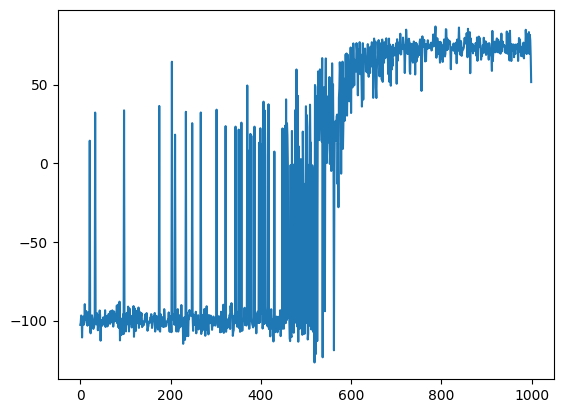

In [6]:
%matplotlib inline

plt.plot(return_list)
plt.show()

In [7]:
%matplotlib qt5

def test_agent(agent, env_name):
    env = gym.make(env_name, render_mode="human")

    state, info = env.reset()

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state, eval = True)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

action_list = test_agent(agent, env_name)

Starting observation: [-0.5662975  0.       ]
Episode finished! Total reward: 72.0941392462131


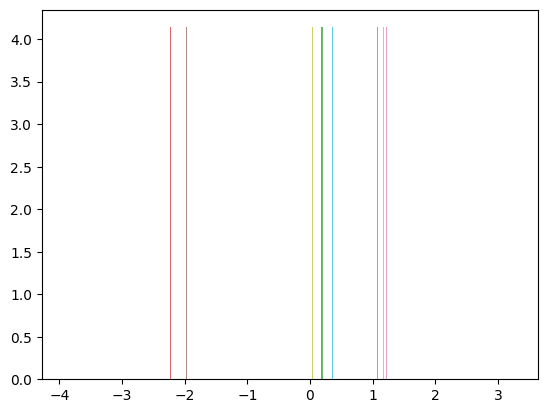

In [13]:
plt.hist(action_list, bins=30, density=True, alpha=0.7)
plt.show()